# Data overview

## Setting up and downloading data

In [140]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [138]:
!wget -O ~/.kaggle/kaggle.json "https://drive.google.com/uc?export=download&id=1eN1kfpt1EQS-KQk-A9M2hWO-uhEBMwE0"
!chmod 600 ~/.kaggle/kaggle.json

--2023-10-22 12:51:10--  https://drive.google.com/uc?export=download&id=1eN1kfpt1EQS-KQk-A9M2hWO-uhEBMwE0
Resolving drive.google.com (drive.google.com)... 142.251.107.113, 142.251.107.138, 142.251.107.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.107.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-80-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aj52k1hsu56pe25bl42mhefar6h6jtbj/1697979000000/12009704024140886017/*/1eN1kfpt1EQS-KQk-A9M2hWO-uhEBMwE0?e=download&uuid=d1acfc57-f9c2-44cf-83aa-e4e14bfb7f87 [following]
--2023-10-22 12:51:11--  https://doc-14-80-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aj52k1hsu56pe25bl42mhefar6h6jtbj/1697979000000/12009704024140886017/*/1eN1kfpt1EQS-KQk-A9M2hWO-uhEBMwE0?e=download&uuid=d1acfc57-f9c2-44cf-83aa-e4e14bfb7f87
Resolving doc-14-80-docs.googleusercontent.com (doc-14-80-docs.googleusercontent.com)... 74.125.26.132, 26

In [139]:
!kaggle competitions download 'child-mind-institute-detect-sleep-states'
!mkdir data
!unzip child-mind-institute-detect-sleep-states.zip -d data

User cancelled operation
mkdir: cannot create directory ‘data’: File exists
Archive:  child-mind-institute-detect-sleep-states.zip
replace data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Analyzing event labels

Importing the necessary libraries:

In [1]:
import gc
import os
import numpy as np
import pandas as pd

Loading the `train_events.csv` input file to a pandas DataFrame:

In [2]:
train_events = pd.read_csv(
    'data/train_events.csv',
    dtype={
        'series_id': 'str',
        'night': 'Int32',
        'event': 'str',
        'step': 'Int64',
    }
)

Parsing the timestamp column from string to datetime type:

In [3]:
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], format='%Y-%m-%dT%H:%M:%S%Z')

### Event labels overview

An overview of the train_events data frame:

In [4]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   series_id  14508 non-null  object
 1   night      14508 non-null  Int32 
 2   event      14508 non-null  object
 3   step       9585 non-null   Int64 
 4   timestamp  9585 non-null   object
dtypes: Int32(1), Int64(1), object(3)
memory usage: 538.5+ KB


In [5]:
display(train_events)

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992,2018-08-14 22:26:00-04:00
1,038441c925bb,1,wakeup,10932,2018-08-15 06:41:00-04:00
2,038441c925bb,2,onset,20244,2018-08-15 19:37:00-04:00
3,038441c925bb,2,wakeup,27492,2018-08-16 05:41:00-04:00
4,038441c925bb,3,onset,39996,2018-08-16 23:03:00-04:00
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604,2017-09-06 04:07:00-04:00
14504,fe90110788d2,34,onset,574620,2017-09-06 23:35:00-04:00
14505,fe90110788d2,34,wakeup,581604,2017-09-07 09:17:00-04:00
14506,fe90110788d2,35,onset,<NA>,NaN


Extracting a list of series from the data frame:

In [6]:
series_list = train_events['series_id'].unique().tolist()
print(series_list[0:10])
print(len(series_list))

['038441c925bb', '03d92c9f6f8a', '0402a003dae9', '04f547b8017d', '05e1944c3818', '062cae666e2a', '062dbd4c95e6', '08db4255286f', '0a96f4993bd7', '0cd1e3d0ed95']
277


As we can see, there are 277 series in the training dataset.

Let's check the event labels for one single time series:

In [7]:
display(train_events[train_events['series_id'] == series_list[0]])

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992,2018-08-14 22:26:00-04:00
1,038441c925bb,1,wakeup,10932,2018-08-15 06:41:00-04:00
2,038441c925bb,2,onset,20244,2018-08-15 19:37:00-04:00
3,038441c925bb,2,wakeup,27492,2018-08-16 05:41:00-04:00
4,038441c925bb,3,onset,39996,2018-08-16 23:03:00-04:00
5,038441c925bb,3,wakeup,44400,2018-08-17 05:10:00-04:00
6,038441c925bb,4,onset,57240,2018-08-17 23:00:00-04:00
7,038441c925bb,4,wakeup,62856,2018-08-18 06:48:00-04:00
8,038441c925bb,5,onset,<NA>,NaN
9,038441c925bb,5,wakeup,<NA>,NaN


We can see that there are null values for `step` and `timestamp` if there was no recorded sleep period for that night.

Below we group together the data by `series_id`, to see roughly how many nights and events are recorded in one series.

In [8]:
grouped = train_events[['series_id', 'night']]
grouped = grouped.groupby(['series_id']).count()

In [9]:
display(grouped)

,night
series_id,
038441c925bb,46
03d92c9f6f8a,74
0402a003dae9,48
04f547b8017d,74
05e1944c3818,16
...,...
fa149c3c4bde,48
fb223ed2278c,106
fbf33b1a2c10,48


In [10]:
grouped.describe()

,night
count,277.000000
mean,52.375451
std,17.811508
min,4.000000
25%,46.000000
50%,48.000000
75%,62.000000
max,168.000000


As we can see, there are about 50 nights in each time series on average.

### Analyzing the length of sleep periods

In [11]:
sleep_lengths = train_events.drop(columns=['step'])
sleep_lengths = sleep_lengths[pd.notna(train_events['timestamp'])]

In [12]:
#sleep_lengths = sleep_lengths[0:10]

In [13]:
def time_delta(x):
  y = x.reset_index()
  if len(y['timestamp']) < 2:
    return np.NaN
  return y['timestamp'][1] - y['timestamp'][0]

In [14]:
sleep_lengths = sleep_lengths.groupby(['series_id', 'night']).agg({'timestamp': time_delta}).rename(columns={'timestamp': 'sleep_length'})
display(sleep_lengths)

sleep_length
series_id    night                
038441c925bb 1     0 days 08:15:00
             2     0 days 10:04:00
             3     0 days 06:07:00
             4     0 days 07:48:00
             6     0 days 09:07:00
...                            ...
fe90110788d2 30    0 days 08:34:00
             31    0 days 08:41:00
             32    0 days 11:23:00
             33    0 days 05:37:00
             34    0 days 09:42:00

[4795 rows x 1 columns]

In [15]:
sleep_lengths.describe()

,sleep_length
count,4790
mean,0 days 08:39:06.350730688
std,0 days 01:41:56.210570414
min,0 days 00:48:00
25%,0 days 07:49:00
50%,0 days 08:51:00
75%,0 days 09:45:00
max,0 days 18:53:00


## Analyzing accelerometer time series

In [16]:
import pyarrow as pa
import pyarrow.parquet

Loading series data and extracting the first series:

In [112]:
series_schema = pa.schema([
    ('series_id', pa.string()),
    ('step', pa.uint32()),
    ('timestamp', pa.string()),
    ('anglez', pa.float32()),
    ('enmo', pa.float32())
])

train_series = pyarrow.parquet.read_table(os.path.join('data/train_series.parquet'), schema=series_schema)
series = train_series.filter(pa.compute.field('series_id') == series_list[0])
series = series.drop(['series_id']).to_pandas()
series['timestamp'] = pd.to_datetime(series['timestamp'], format='%Y-%m-%dT%H:%M:%S%Z')
train_series = None
gc.collect()

6273

Data in the first series:

In [90]:
display(series)

,step,timestamp,anglez,enmo
0,0,2018-08-14 15:30:00-04:00,2.636700,0.0217
1,1,2018-08-14 15:30:05-04:00,2.636800,0.0215
2,2,2018-08-14 15:30:10-04:00,2.637000,0.0216
3,3,2018-08-14 15:30:15-04:00,2.636800,0.0213
4,4,2018-08-14 15:30:20-04:00,2.636800,0.0215
...,...,...,...,...
389875,389875,2018-09-06 04:59:35-04:00,-27.373899,0.0110
389876,389876,2018-09-06 04:59:40-04:00,-27.493799,0.0110
389877,389877,2018-09-06 04:59:45-04:00,-27.533701,0.0111
389878,389878,2018-09-06 04:59:50-04:00,-28.003599,0.0111


In [29]:
import matplotlib.pyplot as plt

In [121]:
def plot_series(series):
  fig, axes = plt.subplots(2, 1, figsize=(12, 6))
  axes[0].plot(series['timestamp'], series['enmo'], lw=0.5)
  axes[0].set_ylabel('enmo')
  axes[0].set_xlabel('time')
  axes[1].plot(series['timestamp'], series['anglez'], lw=0.5)
  axes[1].set_ylabel('anglez')
  axes[1].set_xlabel('time')
  plt.show()

Plot of the whole series (~20 days interval)

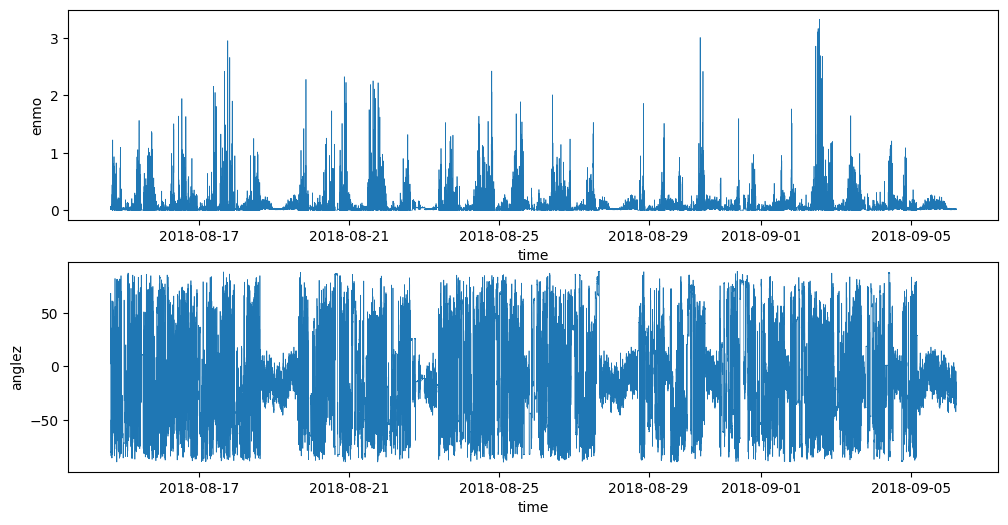

In [122]:
plot_series(series)

Plot of about 2 days interval:

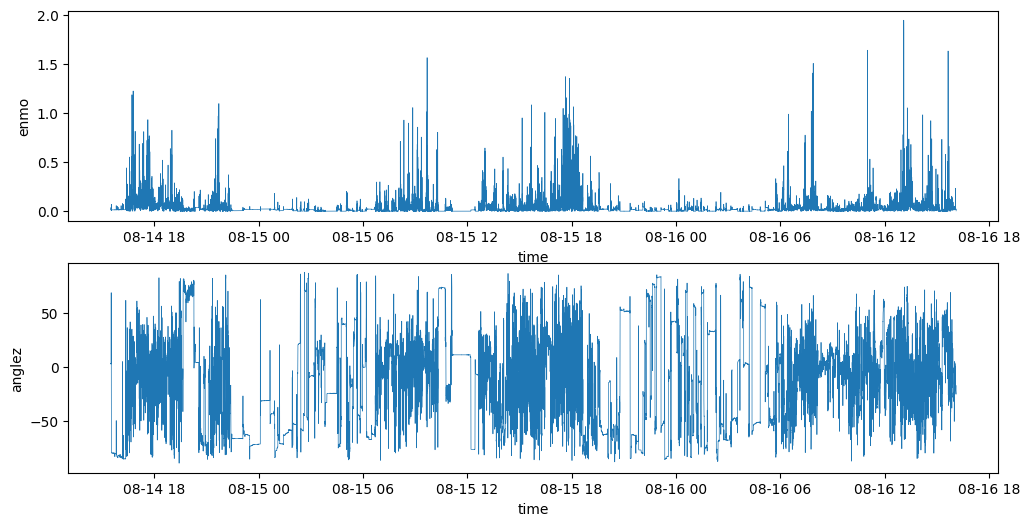

In [123]:
plot_series(series[:35000])

Plot of 60 minutes:

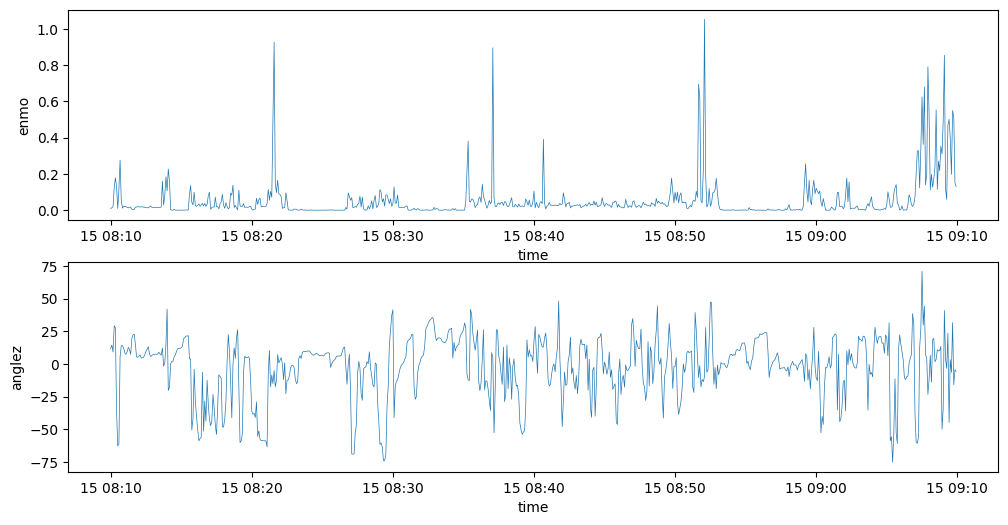

In [126]:
plot_series(series[12000:12720])

## Combining time series and event

In [128]:
series = series[1000:35000]

Events corresponding to the first two nights:

In [129]:
events = train_events[train_events['series_id'] == series_list[0]][0:4]
display(events)

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992,2018-08-14 22:26:00-04:00
1,038441c925bb,1,wakeup,10932,2018-08-15 06:41:00-04:00
2,038441c925bb,2,onset,20244,2018-08-15 19:37:00-04:00
3,038441c925bb,2,wakeup,27492,2018-08-16 05:41:00-04:00


Plot of enmo and anglez for the first two days, where the sleep period is highlighted:

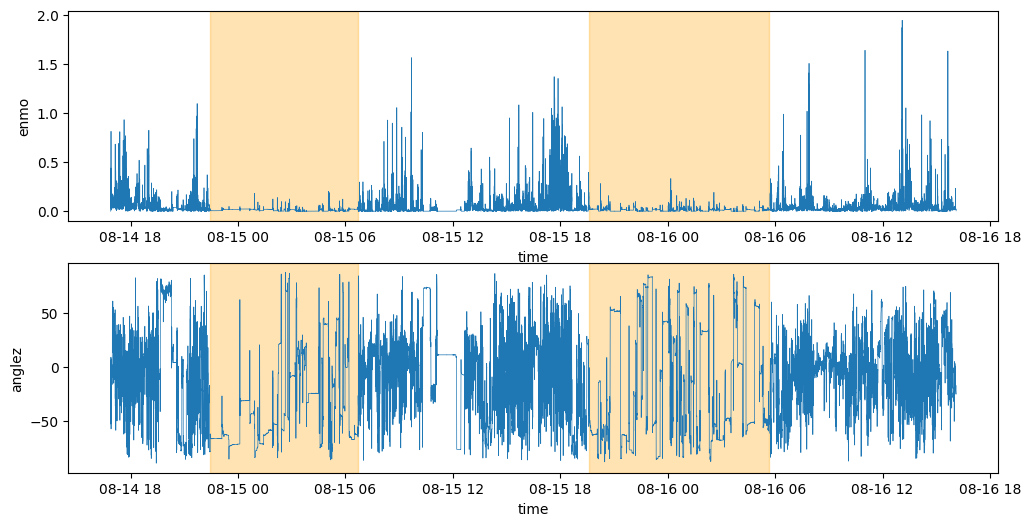

In [130]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].plot(series['timestamp'], series['enmo'], lw=.5)
axes[0].set_ylabel('enmo')
axes[0].set_xlabel('time')
axes[0].axvspan(events['timestamp'][0], events['timestamp'][1], color='orange', alpha=0.3)
axes[0].axvspan(events['timestamp'][2], events['timestamp'][3], color='orange', alpha=0.3)
axes[1].plot(series['timestamp'], series['anglez'], lw=.5)
axes[1].set_ylabel('anglez')
axes[1].set_xlabel('time')
axes[1].axvspan(events['timestamp'][0], events['timestamp'][1], color='orange', alpha=0.3)
axes[1].axvspan(events['timestamp'][2], events['timestamp'][3], color='orange', alpha=0.3)
plt.show()